### ML framework

Using device: cuda
Epoch 0/500000, Loss: 0.7018
Model Accuracy: 0.56
Class 0 Accuracy: 0.63
Class 1 Accuracy: 0.38
Epoch 25000/500000, Loss: 0.6646
Model Accuracy: 0.51
Class 0 Accuracy: 0.52
Class 1 Accuracy: 0.49
Epoch 50000/500000, Loss: 0.6174
Model Accuracy: 0.51
Class 0 Accuracy: 0.56
Class 1 Accuracy: 0.38
Epoch 75000/500000, Loss: 0.5401
Model Accuracy: 0.49
Class 0 Accuracy: 0.54
Class 1 Accuracy: 0.38
Epoch 100000/500000, Loss: 0.4592
Model Accuracy: 0.49
Class 0 Accuracy: 0.54
Class 1 Accuracy: 0.38
Epoch 125000/500000, Loss: 0.3957
Model Accuracy: 0.49
Class 0 Accuracy: 0.56
Class 1 Accuracy: 0.34
Epoch 150000/500000, Loss: 0.3550
Model Accuracy: 0.51
Class 0 Accuracy: 0.55
Class 1 Accuracy: 0.42
Epoch 175000/500000, Loss: 0.3278
Model Accuracy: 0.52
Class 0 Accuracy: 0.56
Class 1 Accuracy: 0.43
Epoch 200000/500000, Loss: 0.3041
Model Accuracy: 0.53
Class 0 Accuracy: 0.57
Class 1 Accuracy: 0.43
Epoch 225000/500000, Loss: 0.2811
Model Accuracy: 0.54
Class 0 Accuracy: 0.60
Cl

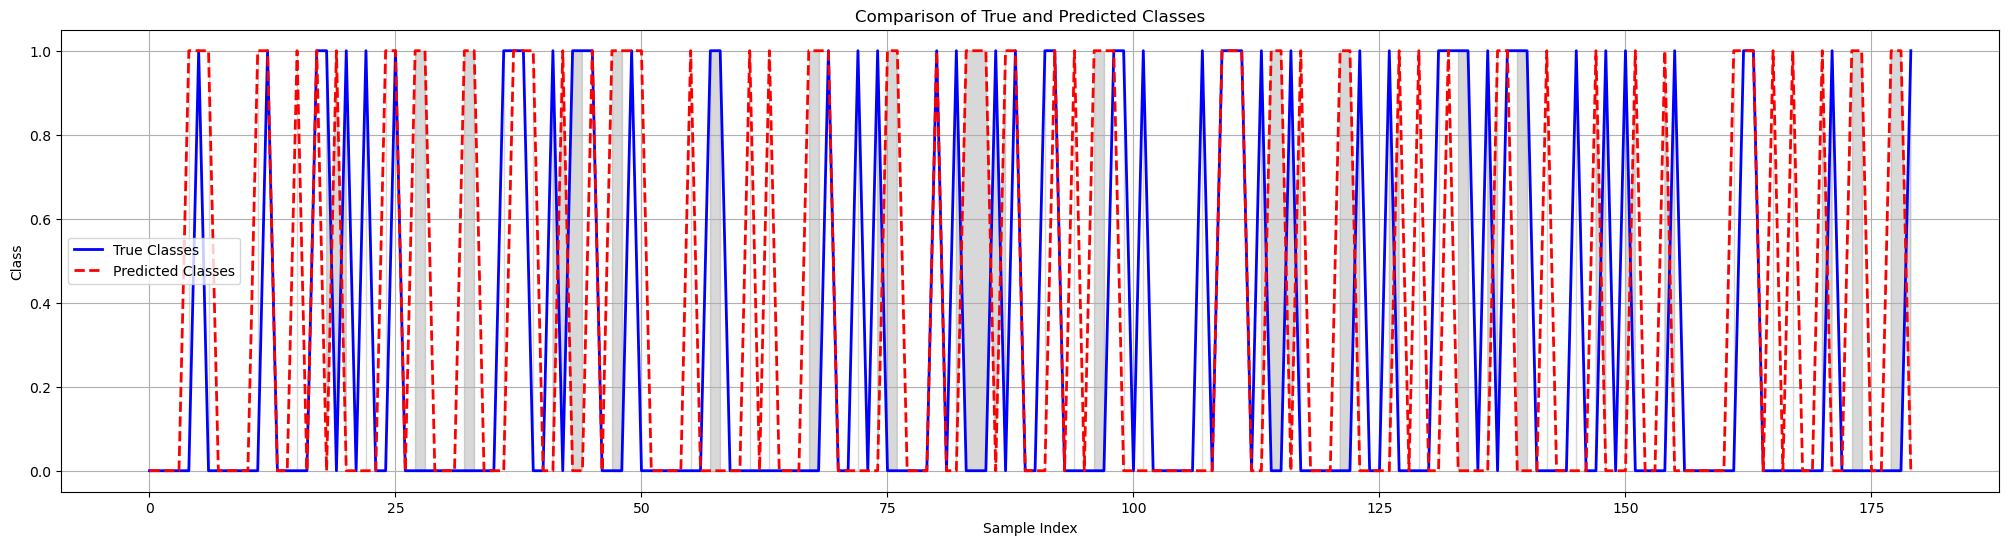

In [5]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import json
import pickle
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support

# Set random seed for reproducibility
torch.manual_seed(26012001)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
url = "C:\\Users\\olegs\\Programming\\StockExperiment\\modules\\ml\\deals.csv"
with open("C:\\Users\\olegs\\Programming\\StockExperiment\\modules\\ml\\headers.json", 'r') as file:
    columns = json.load(file)

# 1. Load and preprocess data
df = pd.read_csv(url, names=columns)
df = df.dropna()
df = df[~df.iloc[:, :-1].replace([float('inf'), -float('inf')], pd.NA).isna().any(axis=1)]

# 2. Encode classes
df["class"] = df["class"].astype("category").cat.codes

# 3. Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(df.iloc[:, :-1].values)
y = df["class"].values

# Convert to PyTorch tensors and move to device
X = torch.FloatTensor(X).to(device)
y = torch.LongTensor(y).to(device)

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=26012001, stratify=y.cpu().numpy()
)
# Move split data to device (train_test_split returns CPU tensors)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Define model
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

# Evaluation function
# Evaluation function with per-class accuracy
def estimate_accuracy(model, X_test, y_test):
    predicted = predict(model, X_test)
    accuracy = (predicted == y_test).float().mean().item()
    
    # Convert tensors to numpy for per-class metrics
    y_pred_np = predicted.cpu().numpy()
    y_true_np = y_test.cpu().numpy()
    
    # Calculate per-class accuracy
    class_0_mask = (y_true_np == 0)
    class_1_mask = (y_true_np == 1)
    
    if class_0_mask.sum() > 0:  # Ensure there are samples for class 0
        class_0_accuracy = (y_pred_np[class_0_mask] == y_true_np[class_0_mask]).mean()
    else:
        class_0_accuracy = 0.0
        print("No samples for class 0 in test set.")
    
    if class_1_mask.sum() > 0:  # Ensure there are samples for class 1
        class_1_accuracy = (y_pred_np[class_1_mask] == y_true_np[class_1_mask]).mean()
    else:
        class_1_accuracy = 0.0
        print("No samples for class 1 in test set.")
    
    return predicted.cpu().numpy(), y_test.cpu().numpy(), accuracy, class_0_accuracy, class_1_accuracy

def train_model(model, X_train, y_train, learning_rate=0.001, epochs=5000, l2_lambda=0.01):
    # Compute class weights (on CPU, then move to device)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.cpu().numpy()), y=y_train.cpu().numpy())
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    # Pass weights to CrossEntropyLoss
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    
    model.train()
    last_loss = 1
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        last_loss = loss.item()
        loss.backward()
        optimizer.step()
        if epoch % 25000 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")
            y_pred_classes, y_test_classes, accuracy, class_0_accuracy, class_1_accuracy = estimate_accuracy(model, X_test, y_test)
            print(f"Model Accuracy: {accuracy:.2f}")
            print(f"Class 0 Accuracy: {class_0_accuracy:.2f}")
            print(f"Class 1 Accuracy: {class_1_accuracy:.2f}")
    print(f"Loss: {loss.item():.4f}")
    
    return model

# Prediction function
def predict(model, X):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
    return predicted

# Visualization function
def visualize(y_pred_classes, y_test_classes):
    x = np.arange(len(y_test_classes))
    plt.figure(figsize=(25, 6))
    plt.plot(x, y_test_classes, label="True Classes", color="blue", linewidth=2)
    plt.plot(x, y_pred_classes, label="Predicted Classes", color="red", linestyle="dashed", linewidth=2)
    plt.fill_between(x, y_test_classes, y_pred_classes, color="gray", alpha=0.3, 
                    where=y_test_classes != y_pred_classes)
    plt.xlabel("Sample Index")
    plt.ylabel("Class")
    plt.title("Comparison of True and Predicted Classes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
should_calculate = True
if should_calculate:
    # Initialize model and move to device
    model = Classifier(input_dim=X_train.shape[1], num_classes=len(torch.unique(y))).to(device)
    
    # Train
    trained_model = train_model(model, X_train, y_train, 
                              learning_rate=0.001, epochs=500000, l2_lambda=0.01)
    
    # Evaluate
    y_pred_classes, y_test_classes, accuracy, class_0_accuracy, class_1_accuracy = estimate_accuracy(trained_model, X_test, y_test)
    print(f"Model Accuracy: {accuracy:.2f}")
    print(f"Class 0 Accuracy: {class_0_accuracy:.2f}")
    print(f"Class 1 Accuracy: {class_1_accuracy:.2f}")
    
    # Visualize
    visualize(y_pred_classes, y_test_classes)
    
    # Save model and scaler
    with open("C:\\Users\\olegs\\Programming\\StockExperiment\\modules\\ml\\model_data.pkl", "wb") as f:
        pickle.dump({
            "means": scaler.mean_,
            "stds": scaler.scale_,
            "state_dict": trained_model.state_dict()
        }, f)

### Проверка torch

Данные собраны с фильтрами: 

1.5:3500

const isCandleCloseDivergence = this.prevCandle.volumeDelta > 0 &&
                                      this.prevCandle.priceDelta < 0 &&
                                      this.prevCandle.volumeDelta / this.prevCandle.volume > 0.4

На статах:

const stat =  {
        price: tick.price,
        isBuyerMaker: tick.isBuyerMaker ? 1 : 0,
        isBestMatch: tick.isBestMatch ? 1 : 0,
        tpToVwap95m: takeProfit / this.analysis.vwap95m.vwap,
        slToVwap95m: stopLoss / this.analysis.vwap95m.vwap,
        tpToVwap245m: takeProfit / this.analysis.vwap245m.vwap,
        slToVwap245m: stopLoss / this.analysis.vwap245m.vwap,
        tpToSma125c: takeProfit / this.analysis.sma125c,
        slToSma125c: stopLoss / this.analysis.sma125c,
        sma125vToVolumeDelta: this.analysis.sma125v / prevCandle.volumeDelta,
        atr14: (stopLoss - takeProfit) / this.analysis.atr14,
        avgTickCountToPcTicks: prevCandle.ticks / this.analysis.avgTickCount.getAvgTickCount(),
        stopLoss: stopLoss / tickPrice,
        takeProfit: takeProfit / tickPrice,
        distanceFactor,
        risk,
        reward,
        pcOpenToClose: prevCandle.open / prevCandle.close,
        pcHighToLow: prevCandle.high / prevCandle.low,
        pcHighToClose: prevCandle.high / prevCandle.close,
        pcHighToOpen: prevCandle.high / prevCandle.open,
        pcLowToClose: prevCandle.low / prevCandle.close,
        pcLowtoOpen: prevCandle.low / prevCandle.open,
        buyVolumeShare: prevCandle.tradedAskContracts / prevCandle.volume,
        sellVolumeShare: prevCandle.tradedBidContracts / prevCandle.volume,
        volumeDeltaShare: prevCandle.volumeDelta / prevCandle.volume,
        pcDivirgence: prevCandle.indicators.deltaDivergence ? 1 : 0,
        vwap95Distance: tick.price - this.analysis.vwap95m.vwap / tick.price,
        vwap245Distance: tick.price - this.analysis.vwap245m.vwap / tick.price,
      }
      

e: 56000 | ma: 0.6595 | wr: 0.19840637450199203 | Class 0 Accuracy: 0.64 | Class 1 Accuracy: 0.58

e: 76000 | ma: 0.6490 | wr: 0.19883527454242927 | Class 0 Accuracy: 0.65 | Class 1 Accuracy: 0.60

e: 96000 | ma: 0.6356 | wr: 0.19531880548829703 | Class 0 Accuracy: 0.67 | Class 1 Accuracy: 0.64

e: 126000 | ma: 0.6072 | wr: 0.19704433497536947 | Class 0 Accuracy: 0.69 | Class 1 Accuracy: 0.68

e: 146000 | ma: 0.5839 | wr: 0.20316205533596837 | Class 0 Accuracy: 0.71 | Class 1 Accuracy: 0.72

e: 166000 | ma: 0.5580 | wr: 0.20032051282051283 | Class 0 Accuracy: 0.72 | Class 1 Accuracy: 0.75

e: 186000 | ma: 0.5267 | wr: 0.20436187399030695 | Class 0 Accuracy: 0.73 | Class 1 Accuracy: 0.77

e: 206000 | ma: 0.4846 | wr: 0.21376518218623483 | Class 0 Accuracy: 0.76 | Class 1 Accuracy: 0.83

e: 226000 | ma: 0.4307 | wr: 0.21901528013582344 | Class 0 Accuracy: 0.81 | Class 1 Accuracy: 0.88

e: 246000 | ma: 0.3781 | wr: 0.22026431718061673 | Class 0 Accuracy: 0.84 | Class 1 Accuracy: 0.91

e: 266000 | ma: 0.3311 | wr: 0.22670250896057348 | Class 0 Accuracy: 0.87 | Class 1 Accuracy: 0.95

e: 286000 | ma: 0.2912 | wr: 0.22706209453197404 | Class 0 Accuracy: 0.89 | Class 1 Accuracy: 0.96

e: 306000 | ma: 0.2630 | wr: 0.23076923076923078 | Class 0 Accuracy: 0.89 | Class 1 Accuracy: 0.96

e: 326000 | ma: 0.2410 | wr: 0.23300970873786409 | Class 0 Accuracy: 0.90 | Class 1 Accuracy: 0.98

e: 346000 | ma: 0.2252 | wr: 0.2355864811133201 | Class 0 Accuracy: 0.91 | Class 1 Accuracy: 0.98

e: 366000 | ma: 0.2136 | wr: 0.235 | Class 0 Accuracy: 0.92 | Class 1 Accuracy: 0.98

e: 466000 | ma: 0.1885 | wr: 0.24429967426710097 | Class 0 Accuracy: 0.94 | Class 1 Accuracy: 0.99

e: 866000 | ma: 0.1731 | wr: 0.2523696682464455 | Class 0 Accuracy: 0.9504 | Class 1 Accuracy: 0.9909

e: 1866000 | ma: 0.1615 | wr: 0.2637889688249401 | Class 0 Accuracy: 0.9623 | Class 1 Accuracy: 0.9909


На статах:
const stat =  {
        price: tick.price,
        priceToSma125c: tick.price / this.analysis.sma125c,
        priceToSma400c: tick.price / this.analysis.sma400c,
        priceSmaDiff: this.analysis.sma125c - tick.price,
        priceToSma400Diff: this.analysis.sma400c - tick.price,
        isBullishDivergenceOnBearishCandle: this.analysis.isBullishDivergenceOnBearishCandle ? 1 : 0,
        isBuyerMaker: tick.isBuyerMaker ? 1 : 0,
        isBestMatch: tick.isBestMatch ? 1 : 0,
        tpToVwap95m: takeProfit / this.analysis.vwap95m.vwap,
        slToVwap95m: stopLoss / this.analysis.vwap95m.vwap,
        tpToVwap245m: takeProfit / this.analysis.vwap245m.vwap,
        slToVwap245m: stopLoss / this.analysis.vwap245m.vwap,
        tpToSma125c: takeProfit / this.analysis.sma125c,
        slToSma125c: stopLoss / this.analysis.sma125c,
        tpToSma400c: takeProfit / this.analysis.sma400c,
        slToSma400c: stopLoss / this.analysis.sma400c,
        sma125vToVolumeDelta: this.analysis.sma125v / prevCandle.volumeDelta,
        sma400vToVolumeDelta: this.analysis.sma400v / prevCandle.volumeDelta,
        atr14: (stopLoss - takeProfit) / this.analysis.atr14,
        avgTickCountToPcTicks: prevCandle.ticks / this.analysis.avgTickCount.getAvgTickCount(),
        stopLoss: stopLoss / tickPrice,
        takeProfit: takeProfit / tickPrice,
        distanceFactor,
        risk,
        reward,
        pcTicks: prevCandle.ticks,
        pcLow: prevCandle.low,
        pcHigh: prevCandle.high,
        pcOpen: prevCandle.open,
        pcClose: prevCandle.close,
        pcVolume: prevCandle.volume,
        pcQuoteVolume: prevCandle.quoteVolume,
        pcOpenToClose: prevCandle.open / prevCandle.close,
        pcHighToLow: prevCandle.high / prevCandle.low,
        pcHighToClose: prevCandle.high / prevCandle.close,
        pcHighToOpen: prevCandle.high / prevCandle.open,
        pcLowToClose: prevCandle.low / prevCandle.close,
        pcLowtoOpen: prevCandle.low / prevCandle.open,
        buyVolumeShare: prevCandle.tradedAskContracts / prevCandle.volume,
        sellVolumeShare: prevCandle.tradedBidContracts / prevCandle.volume,
        volumeDeltaShare: prevCandle.volumeDelta / prevCandle.volume,
        pcDivirgence: prevCandle.indicators.deltaDivergence ? 1 : 0,
        vwap95Distance: tick.price - this.analysis.vwap95m.vwap / tick.price,
        vwap245Distance: tick.price - this.analysis.vwap245m.vwap / tick.price,
      }

e: 1866000 | ma: 0.1886 | wr: 0.27365356622998543 | Class 0 Accuracy: 0.9509 | Class 1 Accuracy: 0.9968

Model Accuracy: 0.96
Class 0 Accuracy: 0.9642
Class 1 Accuracy: 0.9392


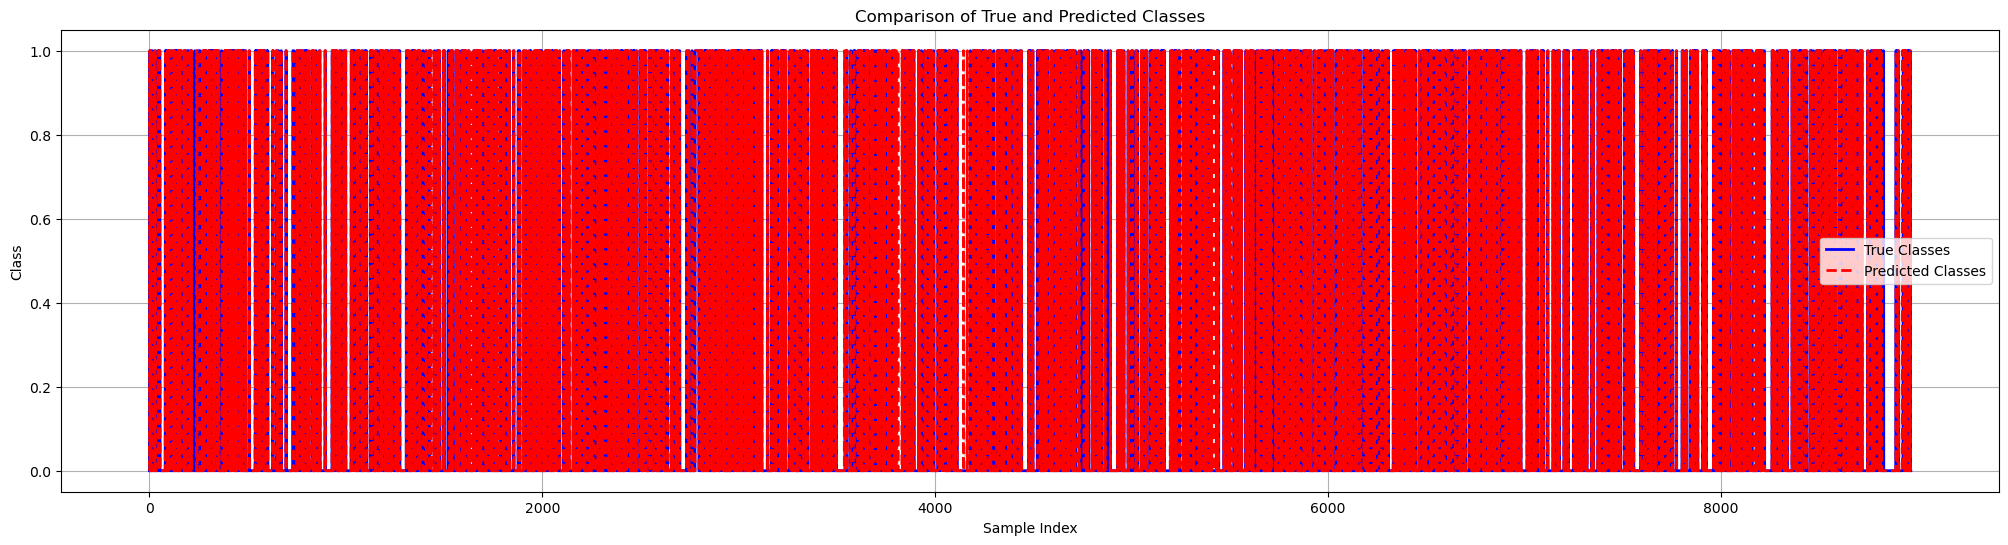

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json

# Define the model class (same as used in training)
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

# 1. Load saved model parameters
with open("C:\\Users\\olegs\\Programming\\StockExperiment\\modules\\ml\\model_data.pkl", "rb") as f:
    model_data = pickle.load(f)

means = np.array(model_data["means"])
stds = np.array(model_data["stds"])
state_dict = model_data["state_dict"]

# Initialize model and load state_dict
input_dim = len(means)
num_classes = state_dict['network.4.bias'].shape[0]  # Final layer's bias
model = Classifier(input_dim=input_dim, num_classes=num_classes)
model.load_state_dict(state_dict)
model.eval()

# 2. Load data for prediction and visualization
url = "C:\\Users\\olegs\\Programming\\StockExperiment\\modules\\ml\\deals.csv"
with open("C:\\Users\\olegs\\Programming\\StockExperiment\\modules\\ml\\headers.json", 'r') as file:
    columns = json.load(file)

df = pd.read_csv(url, names=columns)

# Check for NaN and inf
df = df.dropna()
df = df[~df.iloc[:, :-1].replace([float('inf'), -float('inf')], pd.NA).isna().any(axis=1)]

# Encode classes
df["class"] = df["class"].astype("category").cat.codes

# 3. Standardize features using loaded means and stds
X = df.iloc[:, :-1].values
X_scaled = (X - means) / stds  # Standardize
X_scaled = torch.FloatTensor(X_scaled)  # Convert to PyTorch tensor

# True classes
y_test_classes = df["class"].values

# 4. Prediction for dataset
def predict(X, model):
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
    return predicted.cpu().numpy()

# New prediction function for JSON input
def predict_from_json(json_input):
    """
    Predicts class from a JSON array of features (excluding class).
    JSON array must match the order of columns[:-1].
    """
    try:
        features = np.array(json.loads(json_input), dtype=float)
    except (json.JSONDecodeError, ValueError):
        raise ValueError("Invalid JSON or incorrect data format")
    
    # Validate feature count
    expected_features = len(columns) - 1  # Excluding class
    if features.shape != (expected_features,):
        raise ValueError(f"Expected {expected_features} features, received {features.shape[0]}")
    
    # Standardize
    features_scaled = (features - means) / stds
    features_scaled = torch.FloatTensor(features_scaled).unsqueeze(0)  # Add batch dimension
    
    # Predict
    with torch.no_grad():
        outputs = model(features_scaled)
        predicted_class = torch.argmax(outputs, dim=1).item()
    
    return predicted_class

# 5. Evaluate accuracy on dataset
y_pred_classes = predict(X_scaled, model)
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"Model Accuracy: {accuracy:.2f}")

# Compute per-class accuracies
def compute_per_class_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    class_0_mask = y_true == 0
    class_0_accuracy = np.mean(y_pred[class_0_mask] == y_true[class_0_mask]) if np.sum(class_0_mask) > 0 else np.nan
    
    class_1_mask = y_true == 1
    class_1_accuracy = np.mean(y_pred[class_1_mask] == y_true[class_1_mask]) if np.sum(class_1_mask) > 0 else np.nan
    
    return class_0_accuracy, class_1_accuracy

# Calculate and print per-class accuracies
class_0_acc, class_1_acc = compute_per_class_accuracy(y_test_classes, y_pred_classes)
print(f"Class 0 Accuracy: {class_0_acc:.4f}" if not np.isnan(class_0_acc) else "Class 0 Accuracy: No samples")
print(f"Class 1 Accuracy: {class_1_acc:.4f}" if not np.isnan(class_1_acc) else "Class 1 Accuracy: No samples")

# 6. Visualization
def visualize(y_pred_classes, y_test_classes):
    x = np.arange(len(y_test_classes))
    plt.figure(figsize=(25, 6))
    plt.plot(x, y_test_classes, label="True Classes", color="blue", linewidth=2)
    plt.plot(x, y_pred_classes, label="Predicted Classes", color="red", linestyle="dashed", linewidth=2)
    plt.fill_between(x, y_test_classes, y_pred_classes, color="gray", alpha=0.3, 
                     where=y_test_classes != y_pred_classes)
    plt.xlabel("Sample Index")
    plt.ylabel("Class")
    plt.title("Comparison of True and Predicted Classes")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize(y_pred_classes, y_test_classes)